In [1]:
# 필요한 패키지 설치
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv("walmart_cleaned.csv")

# 데이터 샘플 확인
df

,Unnamed: 0,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,0,1,2010-02-05,0,1.0,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
1,1,1,2010-02-05,0,26.0,11737.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
2,2,1,2010-02-05,0,17.0,13223.76,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
3,3,1,2010-02-05,0,45.0,37.44,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
4,4,1,2010-02-05,0,28.0,1085.29,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,3,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,423281,45,2012-10-26,0,13.0,26240.14,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421566,423282,45,2012-10-26,0,16.0,2660.02,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421567,423283,45,2012-10-26,0,32.0,4131.54,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
421568,423284,45,2012-10-26,0,83.0,717.82,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


In [8]:
#date가 시계열적인 특징 컬럼
#df.info()

df['Date']=pd.to_datetime(df['Date'])

In [13]:
#시계열 정리
df=df.sort_values(by='Date')

In [16]:
# 연도 컬럼 생성
df['Year']=df['Date'].dt.year

In [23]:
## 집계 컬럼 함수 설정

def func(df):
    df_sum= {}
    df_sum['Weekly_Sales'] = df['Weekly_Sales'].sum()
    df_sum['Temperature'] = df['Temperature'].mean()
    df_sum['Fuel_Price'] = df['Fuel_Price'].mean()
    df_sum['IsHoliday'] = df['IsHoliday'].max()
    df_sum['CPI'] = df['CPI'].mean()
    df_sum['Unemployment']= df['Unemployment'].mean()
    return pd.Series(df_sum, index=['Weekly_Sales','Temperature','Fuel_Price','IsHoliday','CPI','Unemployment'])
    

In [24]:
df_agg = df.groupby(['Year','Date']).apply(func).reset_index()

In [25]:
df_agg

,Year,Date,Weekly_Sales,Temperature,Fuel_Price,IsHoliday,CPI,Unemployment
0,2010,2010-02-05,49750740.50,33.277942,2.717869,0.0,167.398405,8.576731
1,2010,2010-02-12,48336677.63,33.361810,2.696102,1.0,167.384138,8.567309
2,2010,2010-02-19,48276993.78,37.038310,2.673666,0.0,167.338966,8.576351
3,2010,2010-02-26,43968571.13,38.629563,2.685642,0.0,167.691019,8.561375
4,2010,2010-03-05,46871470.30,42.373998,2.731816,0.0,167.727351,8.572689
...,...,...,...,...,...,...,...,...
138,2012,2012-09-28,43734899.40,68.151759,3.858245,0.0,175.919639,7.225855
139,2012,2012-10-05,47566639.31,65.456811,3.848435,0.0,175.998254,6.942141
140,2012,2012-10-12,46128514.25,57.687284,3.897425,0.0,176.123786,6.952682
141,2012,2012-10-19,45122410.57,60.152756,3.878413,0.0,176.295499,6.948928


Text(0.5, 1.0, 'Walmart Weekly Sales')

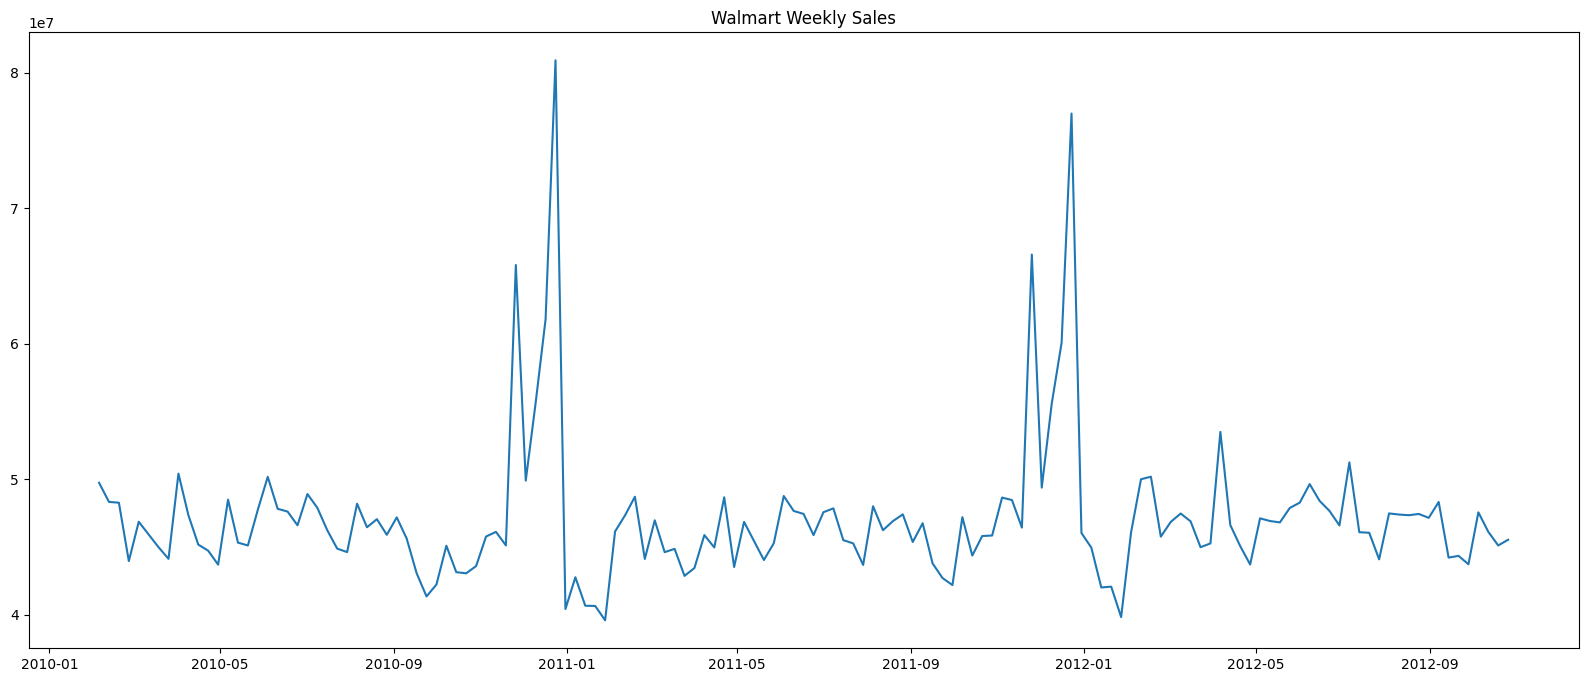

In [29]:
# 전체 매출 트렌드

plt.figure(figsize=(20,8))
plt.plot(df_agg.Date,df_agg.Weekly_Sales)
plt.title('Walmart Weekly Sales')


- 연말에 트렌드가 보인다.
- 계절성이 보이는 것 같다.

In [32]:
## 시계열을 좀 분해하자!
ts_decomp=df_agg.loc[:, ['Date','Weekly_Sales']]
ts_decomp.index = ts_decomp.Date
ts_decomp = ts_decomp.drop('Date',axis=1)

In [34]:
##시계열적인 분해
## 월, 주, 일 나눠보자!
decomp =seasonal_decompose(ts_decomp['Weekly_Sales'], model='additive', period=4) # 월 4주기로 

<Figure size 640x480 with 0 Axes>

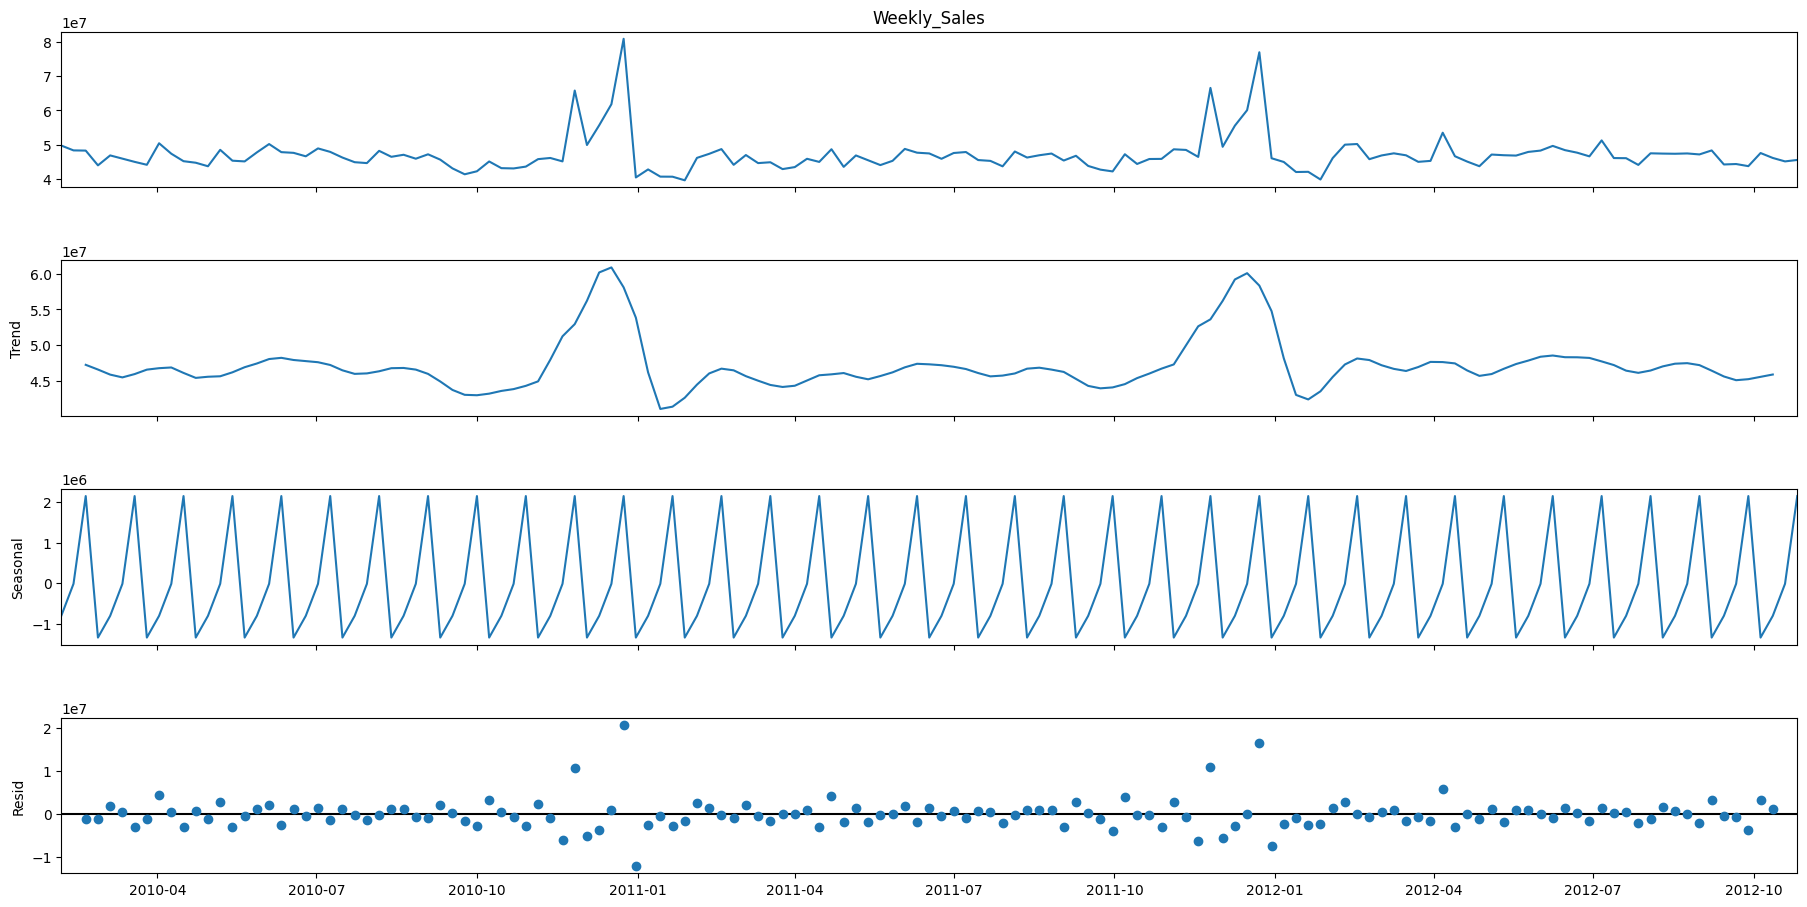

In [37]:
fig = plt.figure()
fig =decomp.plot()
fig.set_size_inches(20,10)

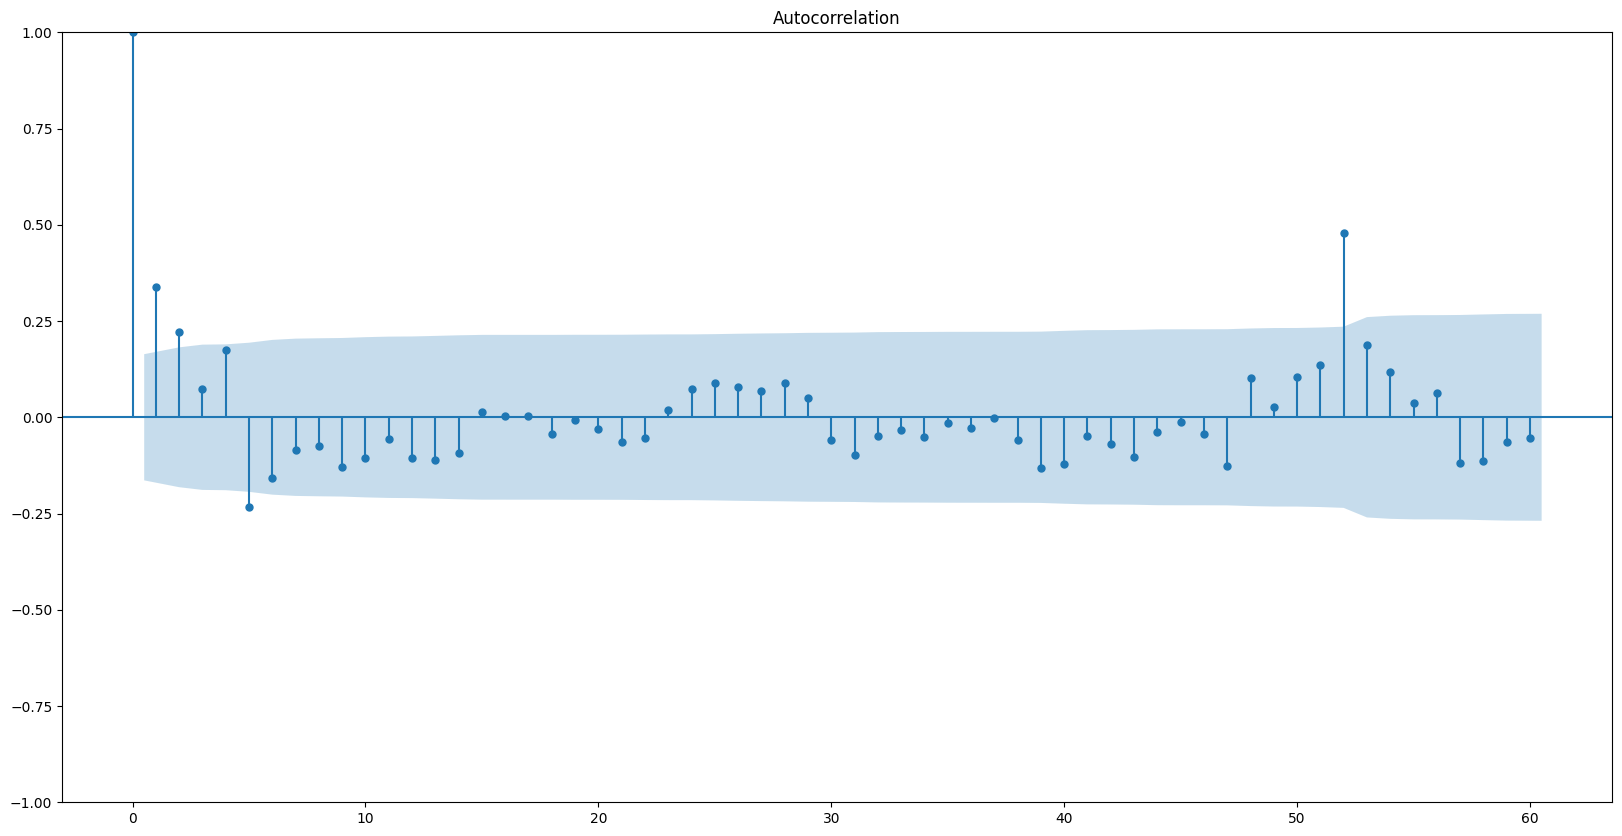

In [42]:
## ACF, PACF 그래프

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(ts_decomp, lags=60, ax= ax1)

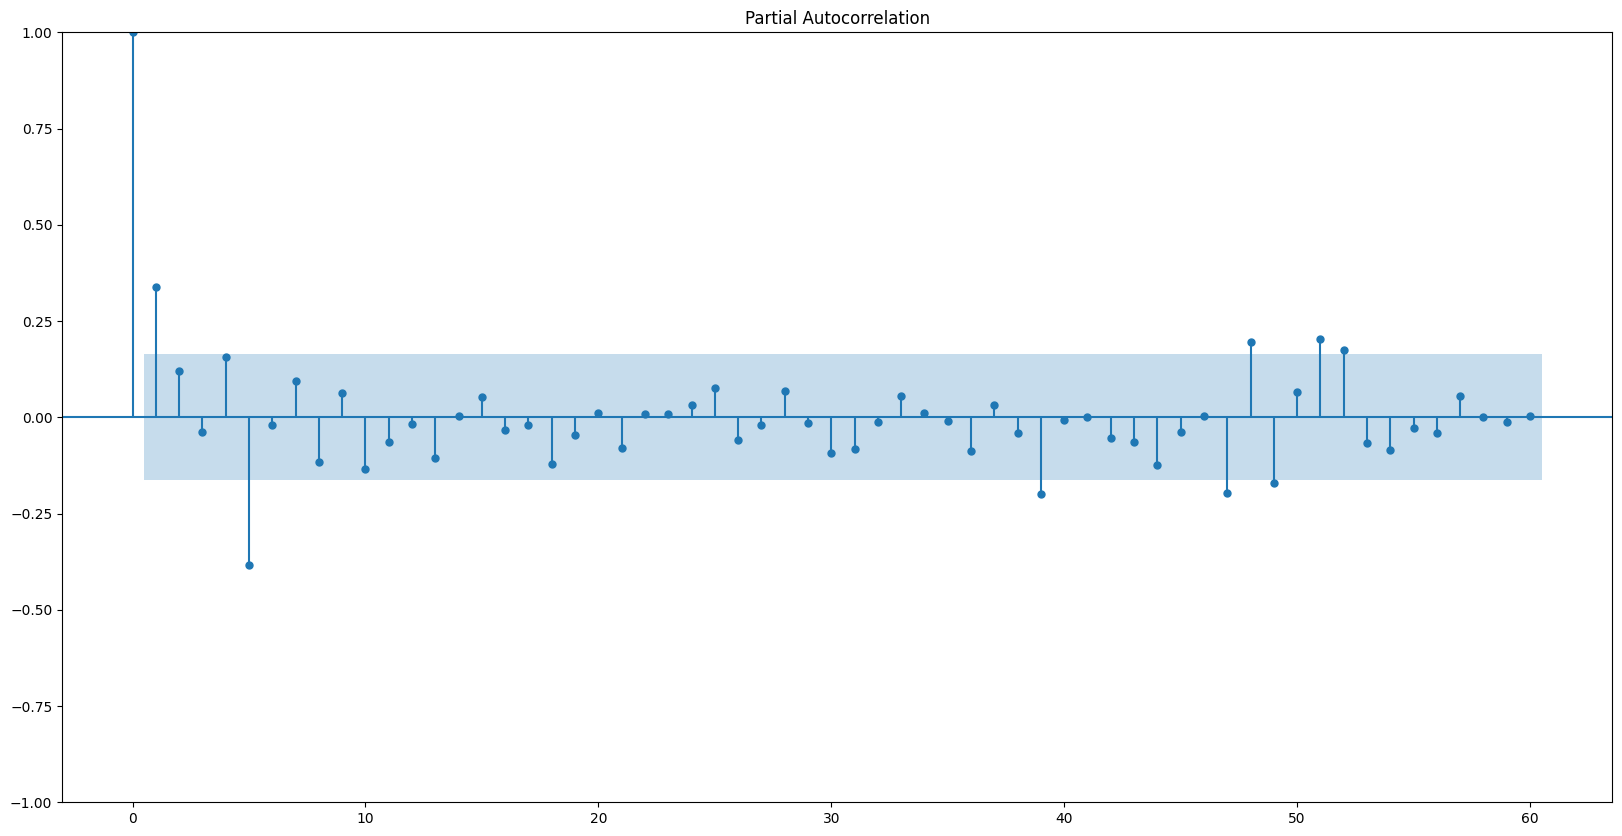

In [43]:
## ACF, PACF 그래프

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(ts_decomp, lags=60, ax= ax1)